# Book: Hands on TinyML
 Chapter 06-01
## Transfer Learning

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

Load the CIFAR-10 database

In [37]:
#Loading dataset

(trainX, trainY), (testX, testY) = cifar10.load_data()

In [38]:
#Analyzing shape of data
print('training set ', '\nData :', trainX.shape, '\nLabel :', trainY.shape)

print('\ntest set', '\nData :', testX.shape, '\nLabel :', testY.shape)

training set  
Data : (50000, 32, 32, 3) 
Label : (50000, 1)

test set 
Data : (10000, 32, 32, 3) 
Label : (10000, 1)


Print sample images

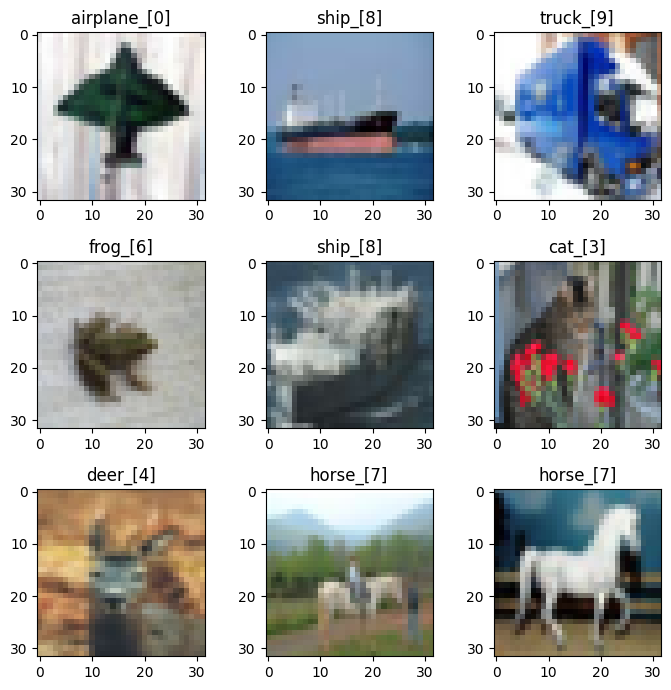

In [39]:
#img = plt.imshow(trainX[1])
from numpy import random
category=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.rcParams['figure.figsize'] = (7,7)

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(trainX))
    plt.imshow(trainX[num], cmap='gray')
    #plt.title("Class {}".format(trainY[num]))
    title="{}_{}".format(category[trainY[num,0]],trainY[num])
    plt.title(title)
plt.tight_layout()
plt.show()

Pre-processing step

In [40]:
#One Hot Encoding Labels from Train and Test Dataset
from tensorflow.keras.utils import to_categorical

trainX = trainX.astype('float32')   # change integers to 32-bit floating point numbers
testX = testX.astype('float32')

trainX /= 255                        # normalize the input
testX /= 255

trainY_one_hot = to_categorical(trainY)
testY_one_hot = to_categorical(testY)

In [41]:
print(trainY_one_hot[1,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Load the pretarined MobileNet model

In [51]:
#Initializing MobileNet as Base Model for Transfer Learning

from tensorflow.keras.applications import MobileNet

pretrained_model = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [52]:
pretrained_model.summary()

Model: "mobilenet_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Define the base layer

In [53]:
#Adding layers to base model of MobileNet

def base_model():

  model = Sequential()
  model.add(Dropout(0.3, input_shape = (1, 1, 1024)))
  model.add(Flatten())

  #Adding the Dense Layers and Dropout
  #model.add(Dense(512,activation=('relu'))) 

  model.add(Dense(128,activation=('relu'))) 

  model.add(Dropout(.3))

  model.add(Dense(10,activation=('softmax')))
  return model

In [54]:
#Visualizing Model Summary

y = pretrained_model
basemodel = base_model()
basemodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,490 (517.54 KB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
!pip install -q tensorflow-model-optimization

Define the complete model with quantization aware training

In [ ]:
#pretrained_model = MobileNet(input_shape=(32, 32, 3), weights='imagenet', include_top=False)
import tensorflow_model_optimization as tfmot

pretrained_model.trainable = True
    
# for layer in pretrained_model.layers[:-1]:
#     layer.trainable = False
    
q_pretrained_model = tfmot.quantization.keras.quantize_model(pretrained_model)
q_base_model = tfmot.quantization.keras.quantize_model(basemodel)
   
original_inputs = tf.keras.layers.Input(shape=(32, 32, 3))
y = q_pretrained_model(original_inputs)
original_outputs = q_base_model(y)

model = tf.keras.Model(original_inputs, original_outputs)
model.summary()

/tmp/ipykernel_15436/3406487481.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(32, 32, 3))


ValueError: `to_quantize` can only either be a keras Sequential or Functional model.

Train the model

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])

NameError: name 'model' is not defined

In [ ]:
#Training Model
hist = model.fit(trainX, trainY_one_hot, batch_size = 100, epochs = 20, 
                 validation_split = 0.1)

Epoch 1/20
450/450 [==============================] - 83s 162ms/step - loss: 1.3329 - accuracy: 0.5438 - val_loss: 0.9601 - val_accuracy: 0.6648
Epoch 2/20
450/450 [==============================] - 72s 160ms/step - loss: 0.8199 - accuracy: 0.7244 - val_loss: 0.7672 - val_accuracy: 0.7422
Epoch 3/20
450/450 [==============================] - 72s 161ms/step - loss: 0.6641 - accuracy: 0.7788 - val_loss: 0.6716 - val_accuracy: 0.7820
Epoch 4/20
450/450 [==============================] - 72s 160ms/step - loss: 0.5811 - accuracy: 0.8112 - val_loss: 0.7450 - val_accuracy: 0.7576
Epoch 5/20
450/450 [==============================] - 72s 160ms/step - loss: 0.5115 - accuracy: 0.8301 - val_loss: 0.6923 - val_accuracy: 0.7820
Epoch 6/20
450/450 [==============================] - 72s 159ms/step - loss: 0.4565 - accuracy: 0.8513 - val_loss: 0.7875 - val_accuracy: 0.7508
Epoch 7/20
450/450 [==============================] - 72s 160ms/step - loss: 0.4164 - accuracy: 0.8652 - val_loss: 0.7582 - val_ac

Evaluate the model

In [ ]:
#Testing accuracy of trained model

model.evaluate(testX, testY_one_hot)[1]

313/313 [==============================] - 14s 42ms/step - loss: 0.8859 - accuracy: 0.7877


0.7876999974250793

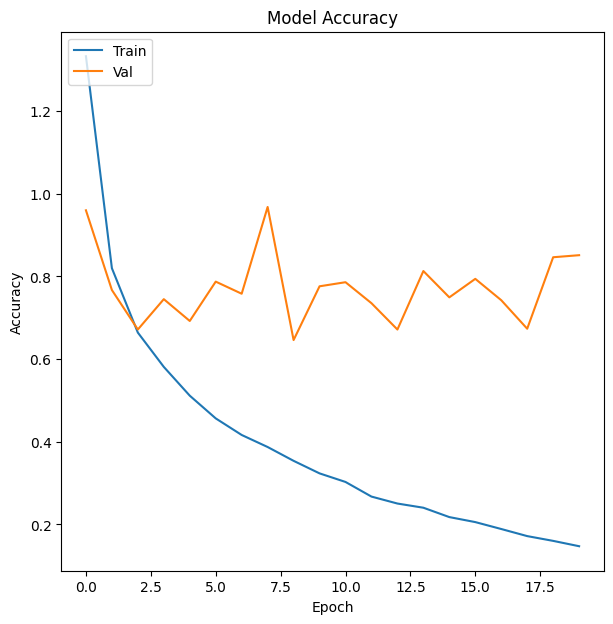

In [ ]:
#Visualizing Model Accuracy

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

Convert into TFLite and save

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_qat = converter.convert()

import pathlib

tflite_models_dir = pathlib.Path("./tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model_qat.tflite"
tflite_model_file.write_bytes(tflite_model_qat)

INFO:tensorflow:Assets written to: /tmp/tmpibmaejwg/assets


INFO:tensorflow:Assets written to: /tmp/tmpibmaejwg/assets
/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-08-23 07:23:29.028074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-23 07:23:29.028210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-23 07:23:29.028678: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpibmaejwg
2025-08-23 07:23:29.066174: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-23 07:23:29.066209: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpibmaejwg
2025-08-23 07:23:29.157462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

3649952

Evaluate the TFLite model on test set

In [ ]:
tflite_model_file = 'tflite_models/model_qat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

pred_list = []
for images in testX:
  input_data = np.array(images, dtype=np.float32)

  input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 3)

  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  prediction = np.argmax(prediction)
  pred_list.append(prediction)

accurate_count = 0
for index in range(len(pred_list)):
  if pred_list[index] == np.argmax(testY_one_hot[index]):
      accurate_count += 1
accuracy = accurate_count * 1.0 / len(pred_list)

print(accuracy)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


0.7876


Create sample JPG files to test on Raspberry Pi

In [ ]:
from numpy import random

from PIL import Image

(trainX, trainY), (testX, testY) = cifar10.load_data()

for i in range(10):
    num = random.randint(0, len(testX))
    im = Image.fromarray(testX[num])
    im.save('sample' +str(i+1)+'.jpg')

In [ ]:
tflite_model_file = 'tflite_models/model_qat.tflite'          
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Im = Image.open('sample1.jpg')
Im_resized = Im.resize((32, 32))
Im = np.asarray(Im_resized)

Im = Im/255

input_data = np.array(Im, dtype=np.float32)

input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1], 3)

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
prediction = interpreter.get_tensor(output_index)
prediction = np.argmax(prediction)


print(prediction)

7


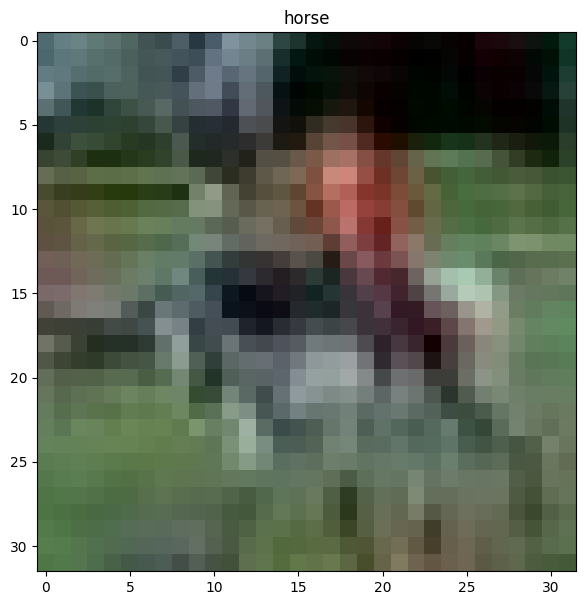

In [ ]:
Im = Image.open('sample1.jpg')
plt.imshow(Im)


plt.title(category[prediction])
#plt.axis('off')
plt.show()